<a href="https://colab.research.google.com/github/sjbaek12/sjbaek12.github.io/blob/master/%EC%A3%BC%ED%83%9D%EA%B0%80%EA%B2%A9_%EC%95%99%EC%83%81%EB%B8%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras

Using TensorFlow backend.


In [2]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

In [3]:
 from sklearn.model_selection import train_test_split

In [4]:
x_train, x_val, y_train, y_val = train_test_split(train_data, train_targets, test_size=0.2, random_state=42)

In [5]:
print(x_train.shape, x_val.shape)

(323, 13) (81, 13)


In [6]:
print(test_data.shape, test_targets.shape)

(102, 13) (102,)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


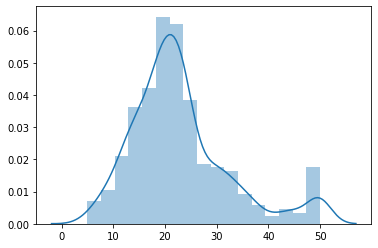

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(y_train)

가격을 로그로 전환해서 예측해 본다. 이경우 원래 가격이 낮을 수록 오차에 대한 손실이 크게 나타난다.

In [8]:
import numpy as np

y_train_log = np.log(y_train)
y_val_log = np.log(y_val)

(323,)


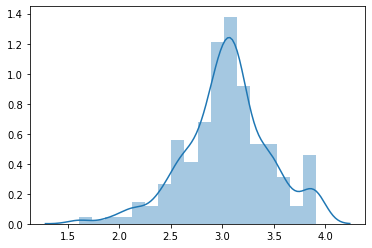

In [9]:
sns.distplot(y_train_log)
print(y_train_log.shape)

In [10]:
mean = x_train.mean(axis=0)
x_train -= mean
std = x_train.std(axis=0)
x_train /= std

# Test data도 정규화를 해준다

x_val -= mean
x_val /= std

test_data -= mean
test_data /= std

In [11]:
from keras.models import Model
from keras import layers
from keras.layers import Dropout # Drop0ut을 사용한다.
from keras import Input
from keras import regularizers # 규제를 사용한다.
import tensorflow as tf

모델의 기본구조이다

In [12]:
input_x = Input(shape=(13,)) # shape=(input_dim,)
middle_x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0))(input_x)
# middle_x = layers.Dropout(0.5)(middle_x)
middle_x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0))(middle_x)
output_y = layers.Dense(1, )(middle_x)
model1 = Model(input_x, output_y)
model1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 13)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


model.prediction에서 log 적용과 비적용을 구분하기 위해서 로그를 활용할 경우 model1 = Model(input_x, output_y)로 구분해 준다

In [13]:
model1 = Model(input_x, output_y)

epochs_num = 100
model1.compile(optimizer=tf.keras.optimizers.RMSprop(0.001), loss='mse', metrics=['mae'])

# y_train_log를 fitting에 사용하였다

history1 = model1.fit(x_train, y_train_log, validation_data=(x_val, y_val_log), epochs=epochs_num, verbose=0)

In [14]:
history1_dic = history1.history
history1_dic.keys()

dict_keys(['val_loss', 'val_mae', 'loss', 'mae'])

In [16]:
print("예측오차 :", history1.history['val_mae'][-1])
print("손실 :", history1.history['val_loss'][-1])

# y_train을 사용하는 것보다 y_train_log를 사용하면 예측오차는 작아진다. 그러면 예측품질이 좋아 진 것인가?

예측오차 : 0.1609112173318863
손실 : 0.044198612602036676


In [17]:
y_val_log_predicted = model1.predict(x_val)

# 모델이 로그로 학습되었으므로 x_val을 넣으면 y_val이 아니라 y_val_log_predict로 값을 가지게 된다

In [18]:
y_val_predicted_from_log = np.exp(y_val_log_predicted)

In [19]:
import matplotlib.pyplot as plt

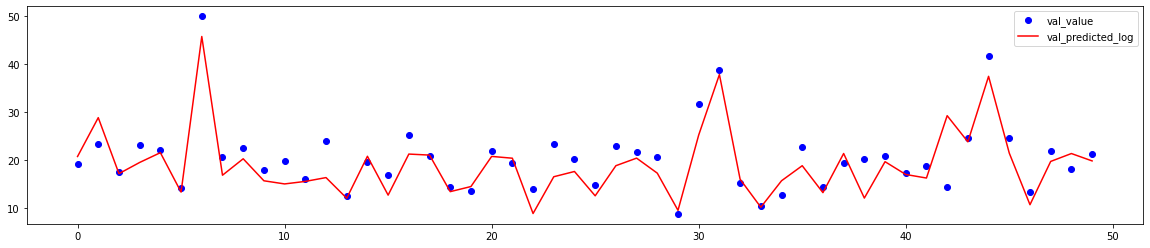

In [20]:
plt.rcParams["figure.figsize"] = (20,4)

plt.plot(y_val[:50], 'bo', label='val_value')
plt.plot(y_val_predicted_from_log[:50], 'r', label='val_predicted_log')
plt.legend()
plt.show()

100.00000000000004

로그로 치환하지 않은 모델은 그냥 model2로 정의한다.

In [21]:
model2 = Model(input_x, output_y)

epochs_num = 100
model2.compile(optimizer=tf.keras.optimizers.RMSprop(0.001), loss='mse', metrics=['mae'])

history2 = model2.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs_num, verbose=0)

In [22]:
history2.history.keys()

dict_keys(['val_loss', 'val_mae', 'loss', 'mae'])

In [23]:
print("예측오차 :", history2.history['val_mae'][-1])
print("손실 :", history2.history['val_loss'][-1])

예측오차 : 2.5484142303466797
손실 : 11.78609009730963


In [25]:
y_val_predicted = model2.predict(x_val)

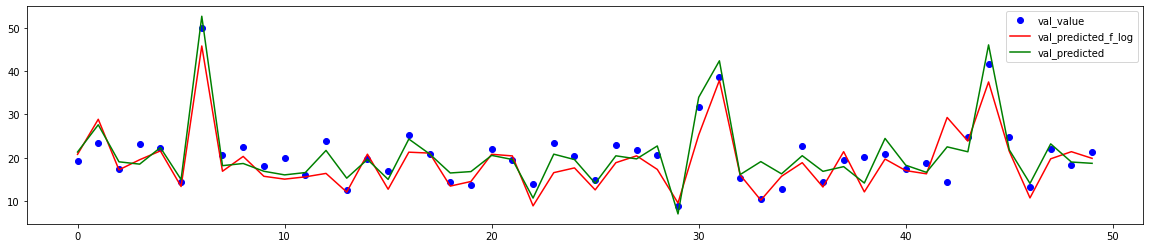

In [26]:
plt.rcParams["figure.figsize"] = (20,4)

plt.plot(y_val[:50], 'bo', label='val_value')
plt.plot(y_val_predicted_from_log[:50], 'r', label='val_predicted_f_log')
plt.plot(y_val_predicted[:50], 'g', label='val_predicted')
plt.legend()
plt.show()

In [27]:
print(np.mean(np.absolute(y_val.reshape(-1,1)- y_val_predicted)))
print(np.mean(np.absolute(y_val.reshape(-1,1)- y_val_predicted_from_log)))

# 전체적인 평가 결과는 log를 사용하지 않은 편이 좋다.

2.548414187961155
3.0611455787847075


In [28]:
y_val1 = y_val.reshape(-1,1)
len(y_val1)

81

In [29]:
y_mean=np.mean(y_train)
print(y_mean)

22.86594427244582


모델을 구분하여 사용하기 위해서 나누어 분석해 본다
주택가격이 평균 이상과 이하로 나눌 경우, log를 사용하면 평균이하에서 평가결과가 우수하고, log를 사용하지 않은 경우에는 평균이상에서 평가결과가 좋다

In [30]:
# 이것은 log를 사용하지 않은 모델이다.
# 결과를 보면 y_val[i]가 평균보다 높을 경우에 손실이 작다

sqe_H = 0
sqe_L = 0
cH = 0
cL = 0

for i in range(len(y_val1)):
  if y_val1[i] >= y_mean:
    sqe = np.square(y_val1[i] - y_val_predicted[i])
    sqe_H += sqe
    cH += 1
  else:
    sqe = np.square(y_val1[i] - y_val_predicted[i])
    sqe_L += sqe
    cL += 1

print("mse_high :", sqe_H/cH)
print("mse_low :", sqe_L/cL)


mse_high : [12.19821903]
mse_low : [11.63241421]


In [31]:
# 이것은 log를 사용한 모델이다.
# 결과를 보면 y_val[i]가 평균보다 낮을 경우에 손실이 작다

sqe_H = 0
sqe_L = 0
cH = 0
cL = 0

for i in range(len(y_val1)):
  if y_val1[i] >= y_mean:
    sqe = np.square(y_val1[i] - y_val_predicted_from_log[i])
    sqe_H += sqe
    cH += 1
  else:
    sqe = np.square(y_val1[i] - y_val_predicted_from_log[i])
    sqe_L += sqe
    cL += 1

print("mse_high_log :", sqe_H/cH)
print("mse_low_log :", sqe_L/cL)

mse_high_log : [28.20423387]
mse_low_log : [11.80765463]


In [64]:
from keras import backend as K

# 메모리 해제
K.clear_session()

두개의 모델을 운영하는 방안이다. 앙상블이라고 보기는 어려운 평균치보다 높을 경우는 비 log 모델을 평균치 보다 낮을 경우 log 모델을 사용하는 방법이다.

In [58]:
y_ps = []
price=0
mean_y_train = np.mean(y_train)
for input, output in zip(x_val, y_val):
  if output >= mean_y_train:
    price = model1.predict(input.reshape(1,13))[0][0]
  if output < mean_y_train:
    price = model2.predict(input.reshape(1,13))[0][0]
  y_ps.append(price)

In [59]:
np.sum(np.absolute(y_ps - y_val))/81

2.5484140761104634

Test_data에 적용한 값이다.

In [42]:
y_ps = []
price=0
mean_y_train = np.mean(y_train)
for input, output in zip(test_data, test_targets):
  if output >= mean_y_train:
    price = model1.predict(input.reshape(1,13))[0][0]
  if output < mean_y_train:
    price = model2.predict(input.reshape(1,13))[0][0]
  y_ps.append(price)

In [43]:
np.sum(np.absolute(y_ps - test_targets))/102

2.817184663286396

In [ ]:
y_val[1]

23.3

In [66]:
model1.predict(x_val[1].reshape(1,13))[0]

array([27.593628], dtype=float32)

In [ ]:
y_val[2]

17.5

In [ ]:
np.mean(y_val)

20.517283950617283

1) Per capita crime rate_범죄율 2) Proportion of residential land zoned for lots over 25,000 square feet_주거지역 비율. 3) Proportion of non-retail business acres per town_비상업지구. 4) Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)_강에 근접여부  5) Nitric oxides concentration (parts per 10 million)_대기오염 6) Average number of rooms per dwelling_방개수 7) Proportion of owner-occupied units built prior to 1940_노후화 8) Weighted distances to five Boston employment centres_직장거리 9) Index of accessibility to radial highways_도로근접성 10) Full-value property-tax rate per $10,000_재산세율 11) Pupil-teacher ratio by town_교육편의성 12) 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town_흑인비율 13) % lower status of the population_하위계층비율

In [ ]:
df_x.loc[0:5,[0,1,2,3,4,5]].values   # DF의 특정 부분을 선택해서 numpy로 전환하는 방법

array([[1.23247e+00, 0.00000e+00, 8.14000e+00, 0.00000e+00, 5.38000e-01,
        6.14200e+00],
       [2.17700e-02, 8.25000e+01, 2.03000e+00, 0.00000e+00, 4.15000e-01,
        7.61000e+00],
       [4.89822e+00, 0.00000e+00, 1.81000e+01, 0.00000e+00, 6.31000e-01,
        4.97000e+00],
       [3.96100e-02, 0.00000e+00, 5.19000e+00, 0.00000e+00, 5.15000e-01,
        6.03700e+00],
       [3.69311e+00, 0.00000e+00, 1.81000e+01, 0.00000e+00, 7.13000e-01,
        6.37600e+00],
       [2.83920e-01, 0.00000e+00, 7.38000e+00, 0.00000e+00, 4.93000e-01,
        5.70800e+00]])

In [ ]:
df_x.loc[0:5]

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72
1,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11
2,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26
3,0.03961,0.0,5.19,0.0,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01
4,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65
5,0.28392,0.0,7.38,0.0,0.493,5.708,74.3,4.7211,5.0,287.0,19.6,391.13,11.74


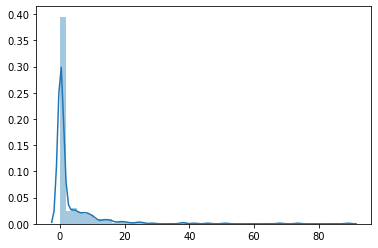

In [ ]:
sns.distplot(df_x.loc[:,[0]])

In [ ]:
import numpy as np

In [ ]:
print(np.log(100) - np.log(80))
print(np.log(80) - np.log(60))
print(np.log(60) - np.log(40))
print(np.log(40) - np.log(20))
print(np.log(20) - np.log(0))

0.2231435513142106
0.2876820724517808
0.40546510810816416
0.6931471805599454
inf


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
